# Session 02 Homework

The goal of this homework is to create a regression model for predicting laptop prices.

In [1]:
# necessary import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

## Get Data
We will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

In [2]:
# url to get the data
laptops_data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

In [3]:
# Download the data
!wget $laptops_data

In [4]:
# Read the dataframe
df = pd.read_csv("laptops.csv")

# Last row
df.tail(1)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
2159,Razer Book FHD+ Intel Evo Core i7-1165G7/16GB/...,Refurbished,Razer,Book,Intel Evo Core i7,16,256,SSD,NaN,13.4,Yes,1699.99


Or we can simply:

In [5]:
# Read the dataframe
df = pd.read_csv(laptops_data)

# Three first Rows
df.head(3)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.0


## Data Preparation

First, let's normalize columns' names:

In [6]:
# Standardize columns'names
df.columns = df.columns.str.lower().str.replace(" ", "_")

We will only use the columns: `ram`,`storage`, `screen` and `final_price` for our analysis:

In [7]:
# Subset the data
df_subset = df[["ram", "storage", "screen", "final_price"]]

## Exploratory data analysis

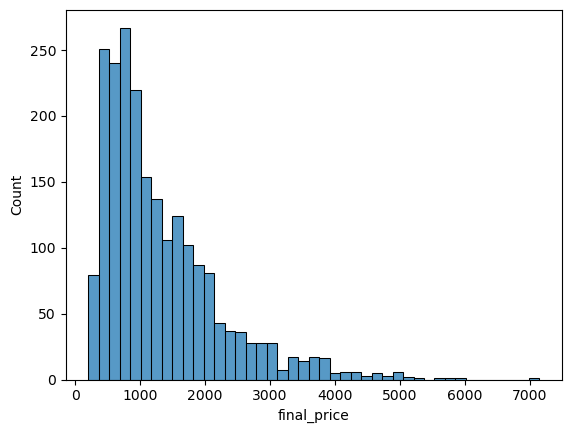

In [8]:
# Prices distribution
sns.histplot(df_subset.final_price)
plt.show()

We can clearly see that the `final_price` has a long tail distribution as shown by this right-skewed histogram. This means that we might need to normalize this distribution later.

### Question 1

Let's check the missing values:

In [9]:
# Sum of missing values per column
df_subset.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

The only column with missing values is `screen`.

### Question 2

The median for `ram` is given by:

In [10]:
# Ram median
df_subset.ram.median()

16.0

## Data Splitting

Let's build a function to perform the validation framework:

In [11]:
# Function for splitting and shuffling data
def shuffle_data(df, seed):
    """
    This function splits the data into train - validation - test sets with
    respectively 60% - 20% - 20% of the original dataframe, shuffles the obtained sets,
    and returns them with new index.
    ---
    df: dataframe
    seed: numpy seed for reproducibility
    """
    # Data set size
    n = len(df)
    # Validation and Test Size
    n_val = n_test = int(n * 0.2)
    # Train set size
    n_train = n - (n_val * 2)
    
    # Create an index
    idx = np.arange(n)
    # Shuffle the index
    np.random.seed(seed) # for reproducibility
    np.random.shuffle(idx)

    # Train - Val - Test splitting
    df_train = df.iloc[idx[ : n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val : ]]

    # Reset indexes
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)
    df_test.reset_index(drop = True, inplace = True)

    # return shuffled data
    return df_train, df_val, df_test

We can now shuffle the dataset for each set to be representative of the original data.

In [12]:
# Train - Validation - test splitting with a seed of 42
df_train, df_val, df_test = shuffle_data(df = df_subset, seed = 42)

# Check the shuffling by visualizing the 3 first rows
df_train.head(3)

,ram,storage,screen,final_price
0,32,1000,15.6,1123.29
1,4,64,14.1,201.05
2,32,1000,14.0,997.74


In [13]:
# Val, test and train sizes
len(df_val), len(df_test), len(df_train)

(432, 432, 1296)

### Question 3

Let's now deal with the missing values of `screen` in different ways and train a regression model to compare the two methods.

In [14]:
# Data Preparation Function
def prepare_X(df, fill_value = 0):
    """
    This function prepares a feature matrix `X`.
    ---
    df: dataframe,
    fill_value: value used for filling missing values if any.
        default: `0`
        Otherwise, please preferably enter a dictionnary or a single value.
    """
    # Remove target feature
    df_num = df.drop(columns = "final_price")

    # Filling missing values
    df_num = df_num.fillna(fill_value)

    # Extract an array
    X = np.array(df_num)

    # return feature matrix
    return X

In [15]:
# Linear regression model traininng
def train_linear_regression(X, y, r = 0):
    """
    Function to train a linear regression model.
    ---
    X: Feature matrix
    y: target vector
    r: regularization parameter if any,
        defalut value: 0 (no regularization)
    """
    # X_0 vector
    ones = np.ones(X.shape[0])   
    # Feature matrix
    X = np.column_stack([ones, X])
    
    # Gram matrix
    XTX = X.T.dot(X)
    # Regularization
    XTX = XTX + r * np.eye(XTX.shape[0])
    # Gram matrix inverse
    XTX_inv = np.linalg.inv(XTX)
    
    # Weights
    w_full = XTX_inv.dot(X.T).dot(y)

    # return slope and coefficients
    return w_full[0], w_full[1 :]

In [16]:
# Root Mean Square Root Error Function
def rmse(y, y_pred):
    """
    Root Mean Square Error between real values and model predictions.
    ---
    y: real values
    y_pred: model predictions
    """
    # Square errors
    se = (y - y_pred) ** 2

    # Mean square error
    mse = se.mean()

    # return root mean square error
    return np.sqrt(mse)

In [17]:
# Funtion to evaluate the model
def evaluate_model(train, val, fill_value = 0, r = 0):
    """
    This function evaluates a linear regression model by returning a rounded rmse.
    ---
    train: training dataframe 
    val: validation dataframe
    fill_value: value used for filling missing values if any,
        default: `0`,
        Otherwise, please preferably enter a dictionnary or a single value
    r: regularization parameter for linear regression
    """
    # Extract targets
    y_train = train.final_price.values
    y_val = val.final_price.values
    
    # Prepare training data
    X_train = prepare_X(train, fill_value)
    
    # Linear Regression
    w0, w = train_linear_regression(X_train, y_train, r)
    
    # Prepare validation data
    X_val = prepare_X(val, fill_value)
    
    # Make predictions on validation data
    y_pred = w0 + X_val.dot(w)
    
    # Rounded RMSE on validation data
    score = rmse(y_val, y_pred)

    # return score
    return round(score, 2)

**When filling missing values with 0:**

In [18]:
# Model RMSE score when filling missing values with 0
evaluate_model(train = df_train, val = df_val, fill_value = 0)

597.36

**When filling missing values with the mean of the variable:**

In [19]:
# Model RMSE score when filling missing values with columns' means
evaluate_model(train = df_train, val = df_val, fill_value = df_train.mean().to_dict())

600.27

The best option is to fill missing values with 0.

### Question 4

Let's train a regularized linear regression, filling missing values with `0`. We will try different values for the regularization parameter `r` from the list: `[0, 0.01, 0.1, 1, 5, 10, 100]` and evaluate the models to choose the best value of `r`.

In [20]:
# Bunch of values for the hyperparameter
params = [0, 0.01, 0.1, 1, 5, 10, 100]

# Initialize results
results = []

# Model Fine Tuning with parameters
for param in params:
    # store model evaluation score into results
    results += [evaluate_model(train = df_train, val = df_val, fill_value = 0, r = param)]

# Visualize the results
pd.Series(data = results, index = params, name = "parameters_results")

0.00      597.36
0.01      597.36
0.10      597.35
1.00      597.21
5.00      597.01
10.00     597.06
100.00    597.90
Name: parameters_results, dtype: float64

The value of `r` giving the best result among the given options is `10`.

### Question 5

We will find out how selecting the seed influences our score by trying different seed values from: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`. For each seed, we will split the data into train , validation and test, then fill the missing values with `0` and train the model without regularization. All the scores will then be collected.

In [21]:
# Bunch of values for seeds
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Initialize results
results = []

# Model Fine Tuning with data splitting
for s in seeds:
    # Train - Validation - test
    df_train, df_val, df_test = shuffle_data(df = df_subset, seed = s)

    # store model evaluation score into results
    results += [evaluate_model(train = df_train, val = df_val, fill_value = 0, r = 0)]

# Visualize the results
rmse_seeds = pd.Series(data = results, index = seeds, name = "seeds_results")
rmse_seeds

0    565.45
1    636.80
2    588.96
3    597.81
4    571.96
5    573.24
6    647.34
7    550.44
8    587.33
9    576.10
Name: seeds_results, dtype: float64

In [22]:
# Standard deviation of all scores
std = np.std(rmse_seeds)
round(std, 3)

29.176

### Question 6

Let's split the dataset using the seed `9`, combine train and validation datasets, fill the missing values with 0 and train a model with `r = 0.001`.

In [23]:
# Train - Validation - test with a seed of `9`
df_train, df_val, df_test = shuffle_data(df = df_subset, seed = 9)

# Combine Training and Validation sets
df_full_train = pd.concat([df_train, df_val])

# model evaluation score on the test dataset
evaluate_model(train = df_full_train, val = df_test, fill_value = 0, r = 0.001)

608.61

---